# N-Beats neural network usage analysis in heart condition classification based on ECG signal.
Author: Bartosz Puszkarski

## Basic concept
In this project I was trying to use N-Beats neural network to regress a continuation of ECG signal of a given history using differently trained models to create a curve as much similar to the original as it is possible. Based on those regressions I wanted to measure the distance from the original curve and this disctance was a decisive part of the classification process - the lower the distance, the degree of certainty was higher.

## Code init

In [1]:
import os

import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import nbeats_additional_functions as naf

from nbeats_pytorch.model import NBeatsNet

import torch
from torch import optim
from torch.nn import functional as F

## Net description

## Classifier model class

In [2]:
class Model:
    def __init__(self, device=torch.device('cpu')):
        self.forecast_length = 500
        self.backcast_length = 3 * self.forecast_length
        self.batch_size = 256
        self.classes = ['LBBB', 'STD', 'Normal', 'RBBB', 'AF', 'I-AVB', 'STE', 'PAC', 'PVC']
        self.device = device
        self.nets = {}
        self.scores = {}
        self.scores_norm = {}
        self.scores_final = {}

    def load(self):
        for d in self.classes:
            checkpoint = d + "_nbeats_checkpoint.th"
            net = NBeatsNet(stack_types=[NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK],
                            forecast_length=self.forecast_length,
                            thetas_dims=[7, 8],
                            nb_blocks_per_stack=3,
                            backcast_length=self.backcast_length,
                            hidden_layer_units=128,
                            share_weights_in_stack=False,
                            device=self.device)
            optimiser = optim.Adam(net.parameters())

            naf.load(checkpoint, net, optimiser)
            self.nets[d] = net

    def predict(self, data, data_header):
        x, y = naf.organise_data(data, data_header, self.forecast_length, self.backcast_length, self.batch_size)
        for c in self.classes:
            self.scores[c] = naf.get_avg_score(self.nets[c], x , y)

        scores = list(self.scores.values())

        print(self.scores)
        max_score = max(scores)
        min_score = min(scores)
        result = {}
        for c in self.classes:
            self.scores_norm[c] = (self.scores[c] - min_score) / (max_score - min_score)
            self.scores_final[c] = 1 - self.scores_norm[c]
            result[c] = 0
            if self.scores_final[c] > 0.99:
                result[c] = 1

        return result


## Data description
The dataset used in this project is the one provided by the PhysionetChallenge and is coming from different sources and databases:

Southeast University, China, including the data from the China Physiological Signal Challenge 2018
Centre for Cardiometabolic Risk Reduction in South-Asia (CARRS), India, and a diverse population in the USA.

A majority of data which I have used in my training process is taken from China Physiological Signal Challenge in 2018 and it consists of 6877 12-ECG recordings varying in length between 6 - 60s. All of the recordings were sampled with the same frequency which allowed me to specify my horizont length and was set to 500 Hz. ECG recordings are constructed containing a binary MATLAB v4 file for the  signal data and a text file with WFDB header format describing the recording parameters as **length**, **frequency**, **date** and **patient attributes**. This header also contains the most important imformation of the dataset, which is undoubtedly a base of the whole learning process - the targeted heart condition associated with the gives signal. Below an examplar file A0001.hea is presented:

A0001 12 500 7500 05-Feb-2020 11:39:16
A0001.mat 16+24 1000/mV 16 0 28 -1716 0 I
A0001.mat 16+24 1000/mV 16 0 7 2029 0 II
A0001.mat 16+24 1000/mV 16 0 -21 3745 0 III
A0001.mat 16+24 1000/mV 16 0 -17 3680 0 aVR
A0001.mat 16+24 1000/mV 16 0 24 -2664 0 aVL
A0001.mat 16+24 1000/mV 16 0 -7 -1499 0 aVF
A0001.mat 16+24 1000/mV 16 0 -290 390 0 V1
A0001.mat 16+24 1000/mV 16 0 -204 157 0 V2
A0001.mat 16+24 1000/mV 16 0 -96 -2555 0 V3
A0001.mat 16+24 1000/mV 16 0 -112 49 0 V4
A0001.mat 16+24 1000/mV 16 0 -596 -321 0 V5
A0001.mat 16+24 1000/mV 16 0 -16 -3112 0 V6
#Age: 74
#Sex: Male
#Dx: RBBB
#Rx: Unknown
#Hx: Unknown
#Sx: Unknown

## Data visualisation

/home/puszkarb/.local/share/virtualenvs/puszkarb-IgcIsVC8/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


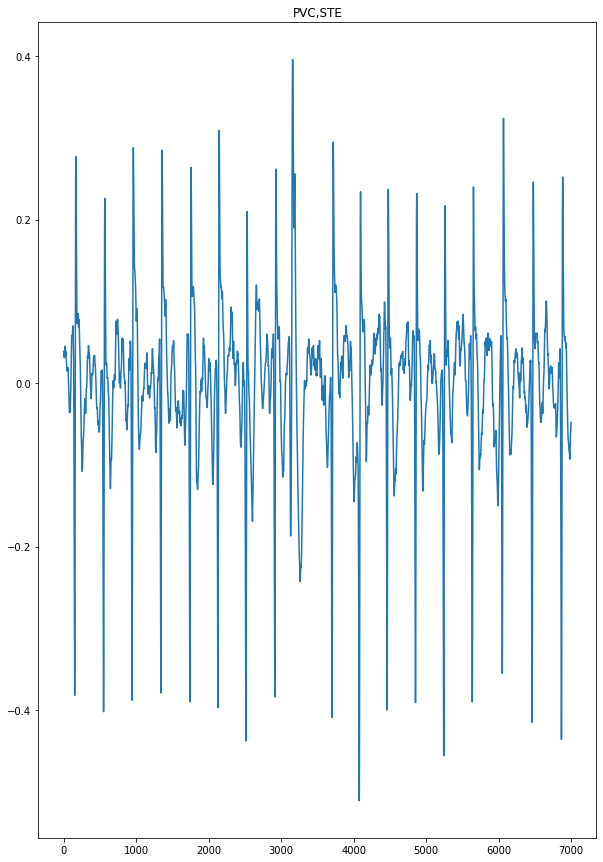

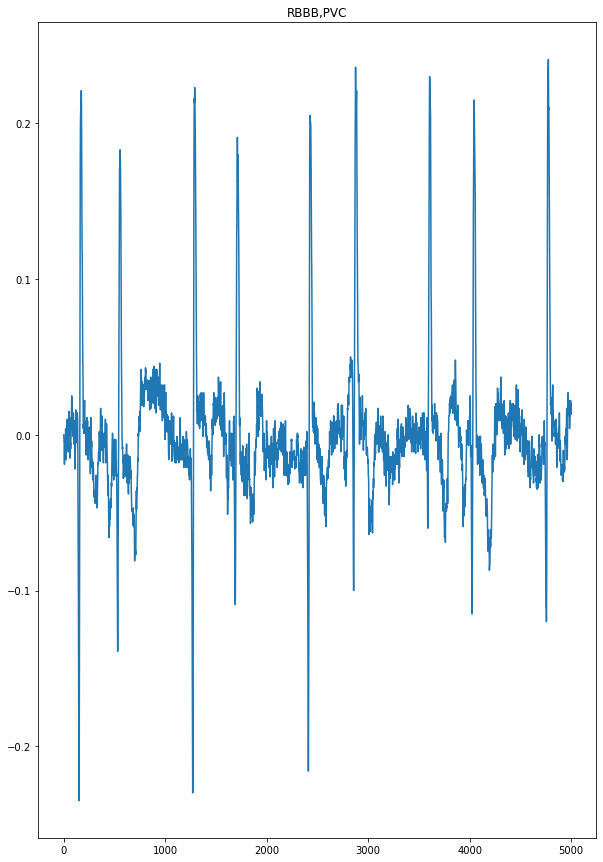

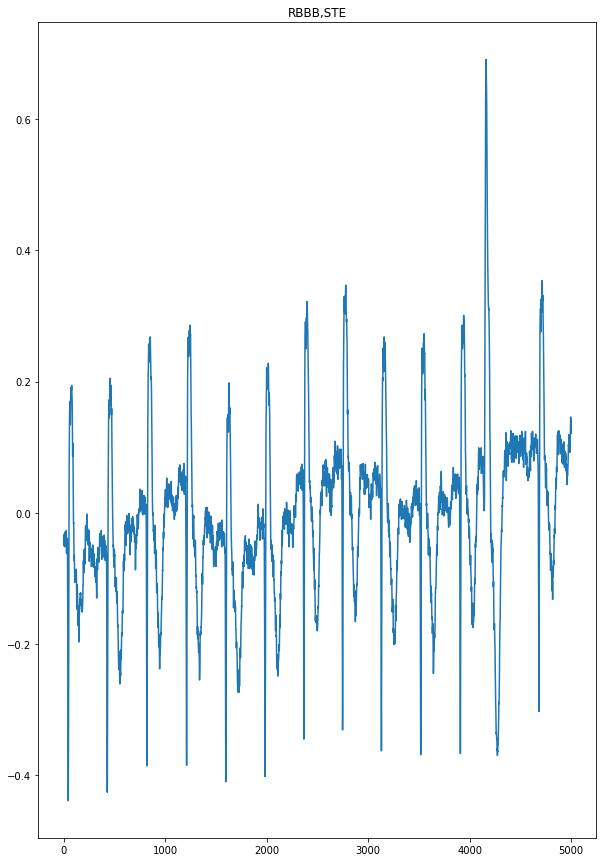

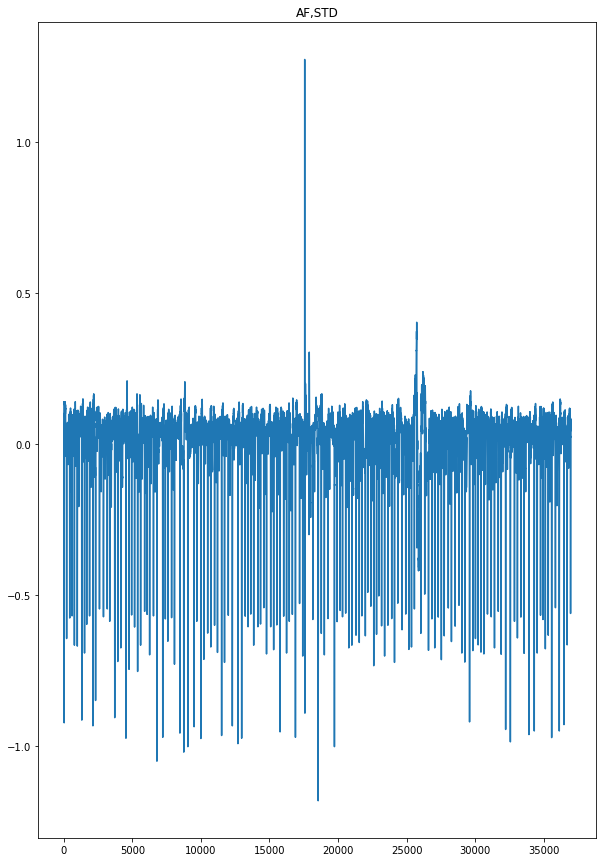

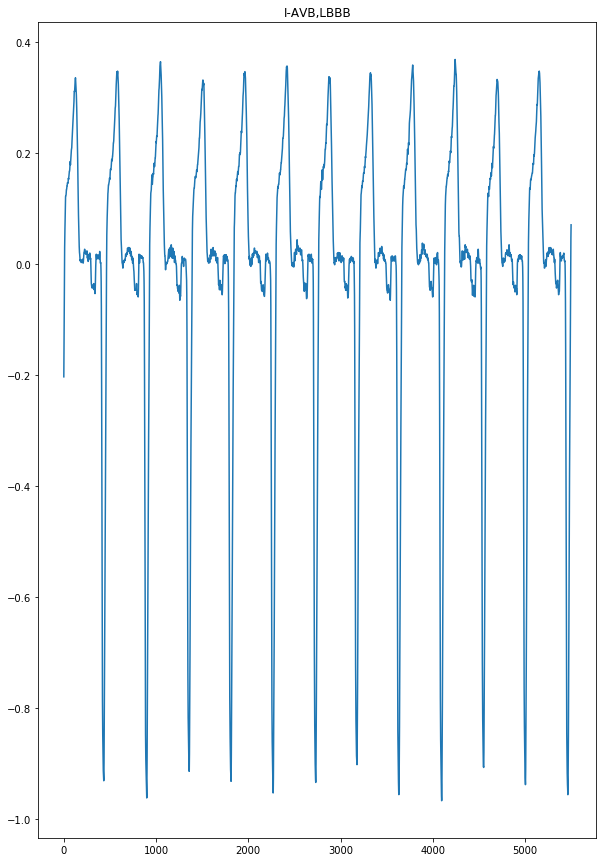

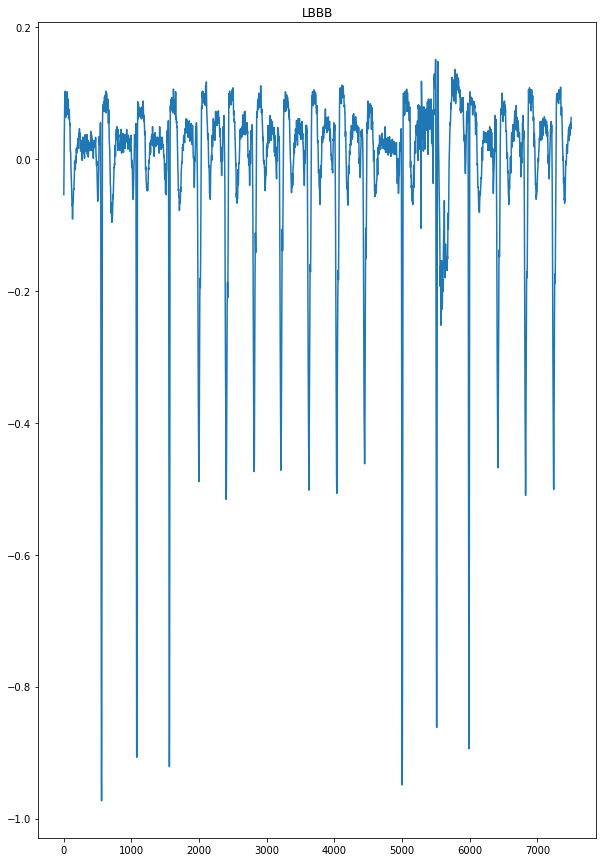

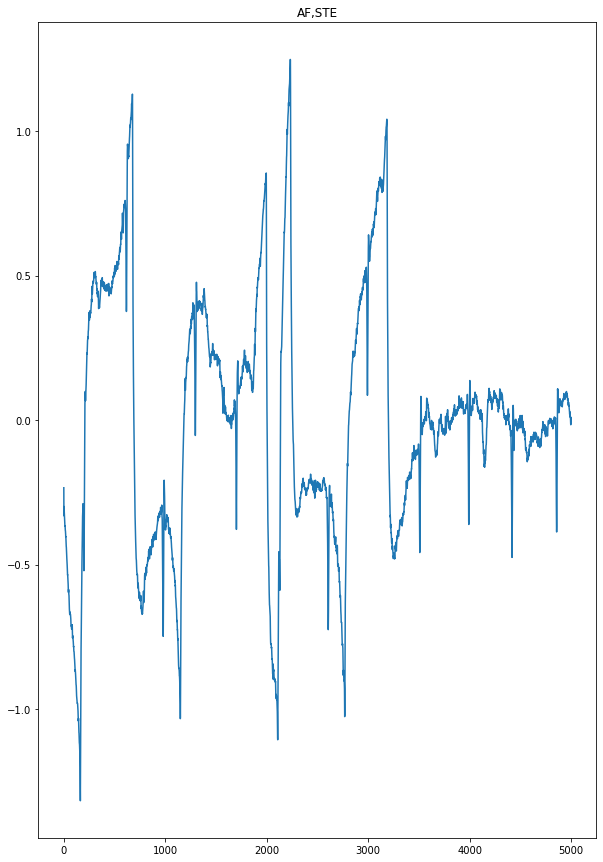

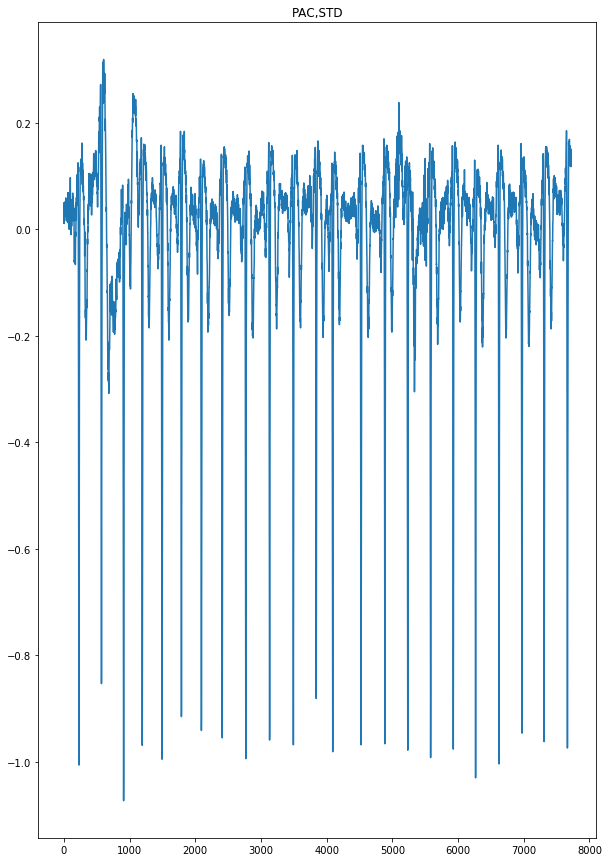

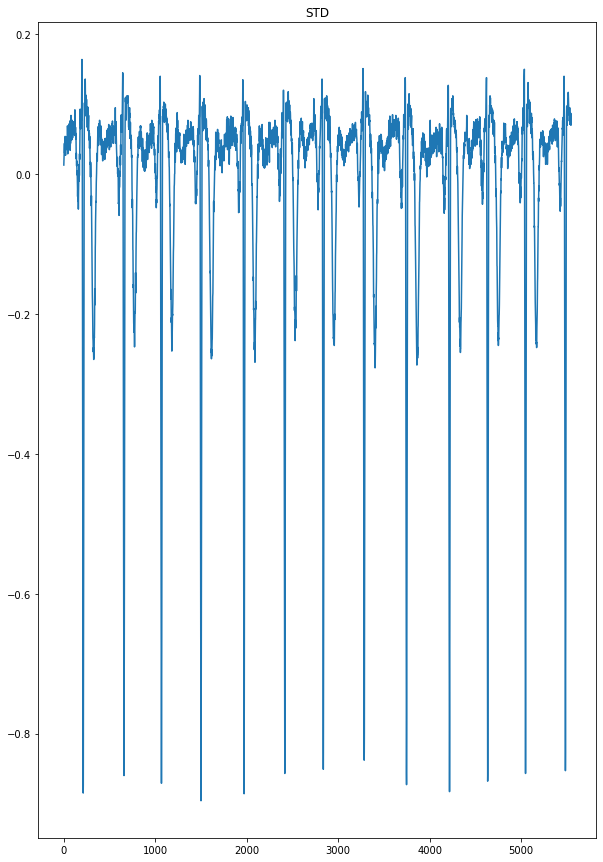

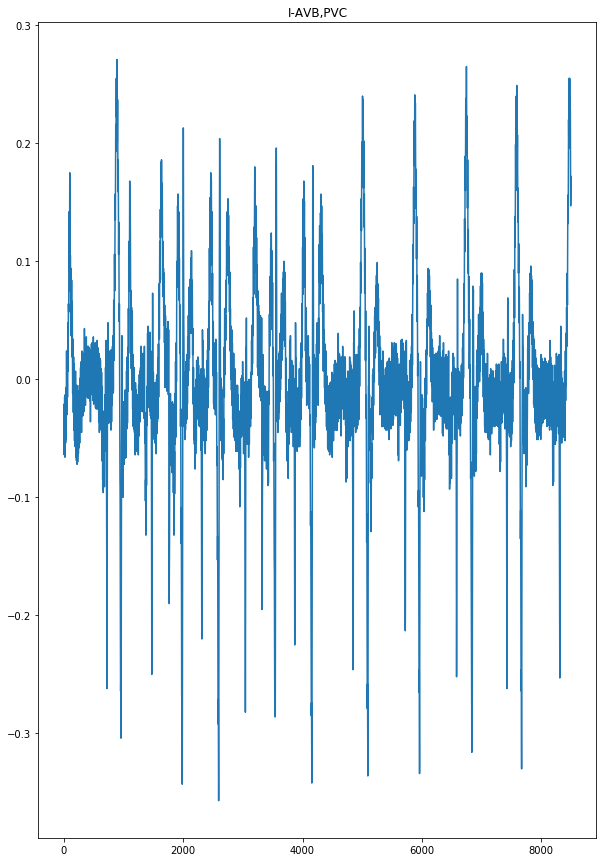

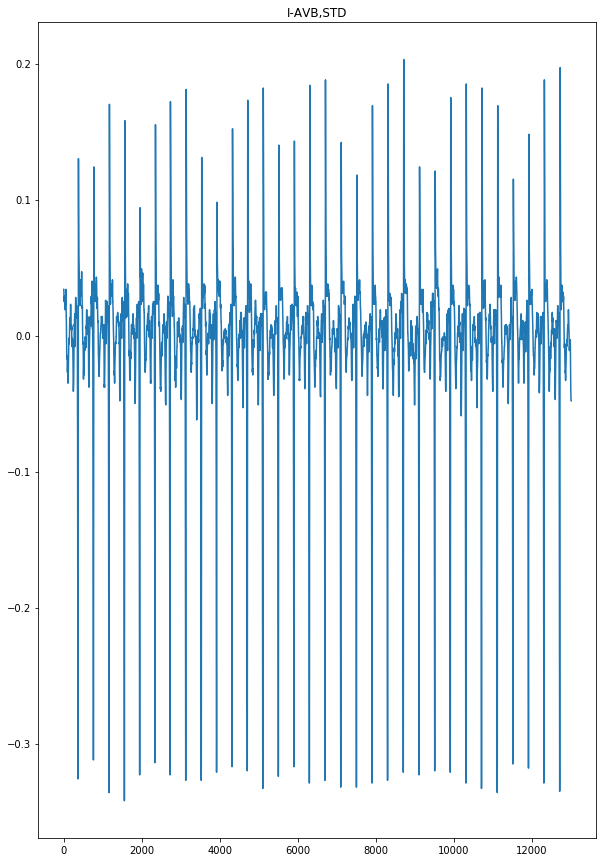

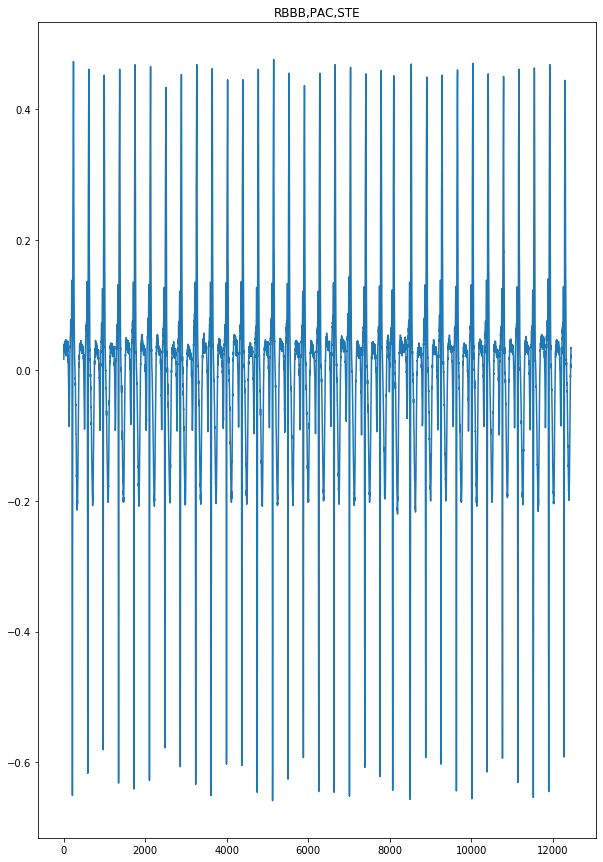

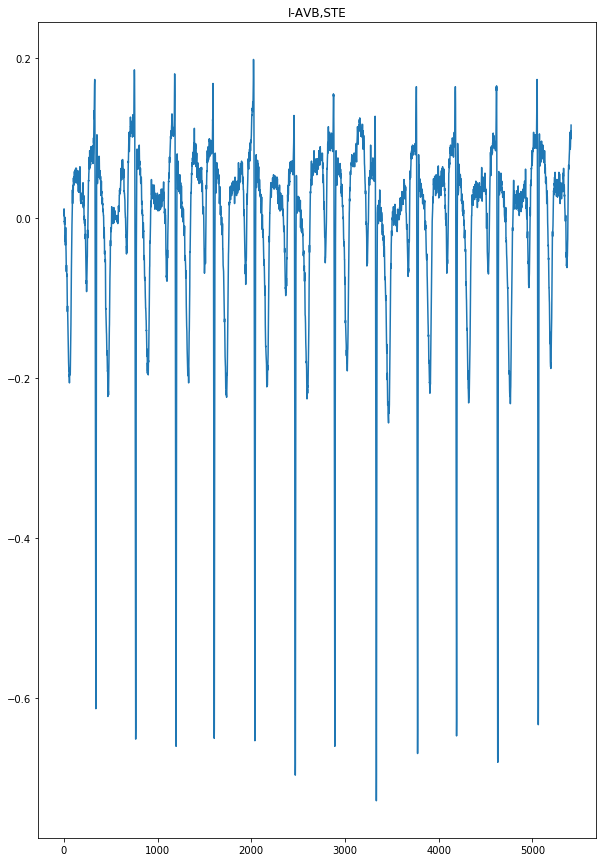

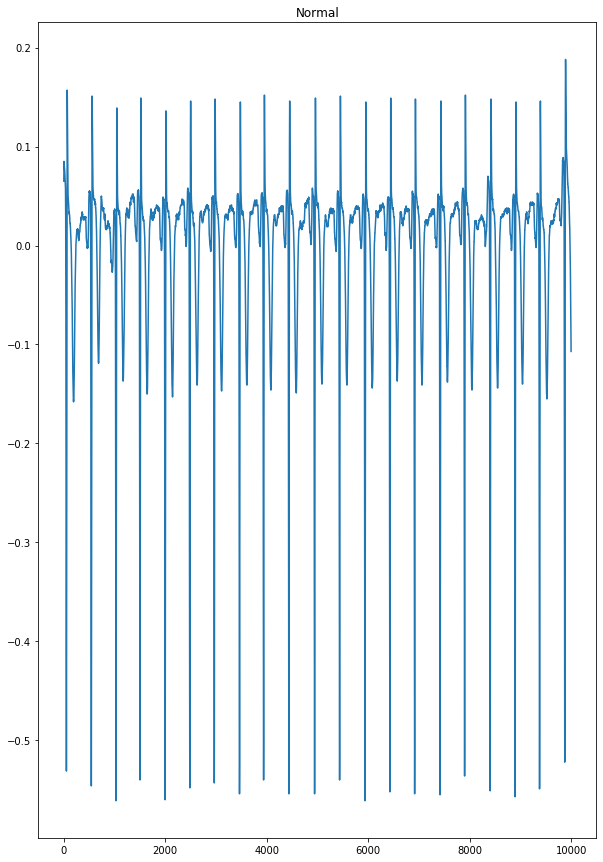

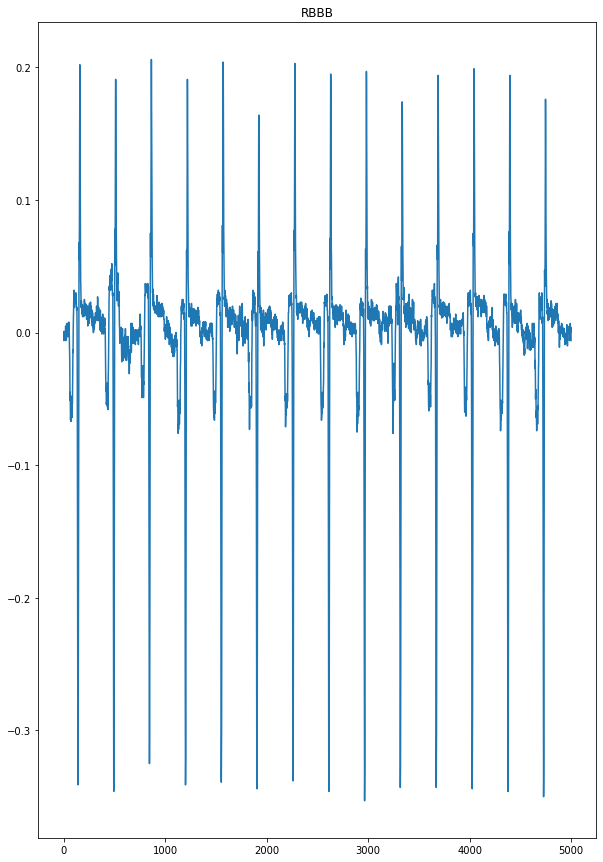

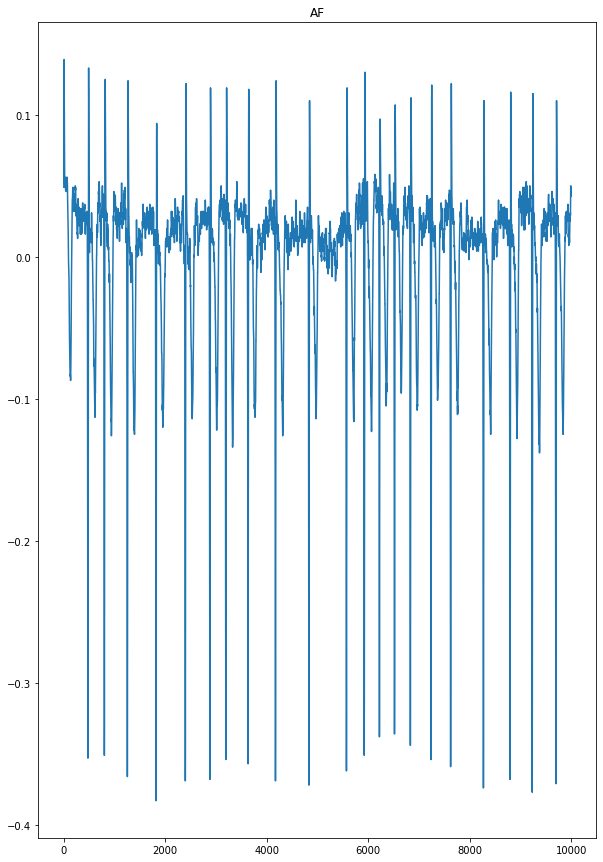

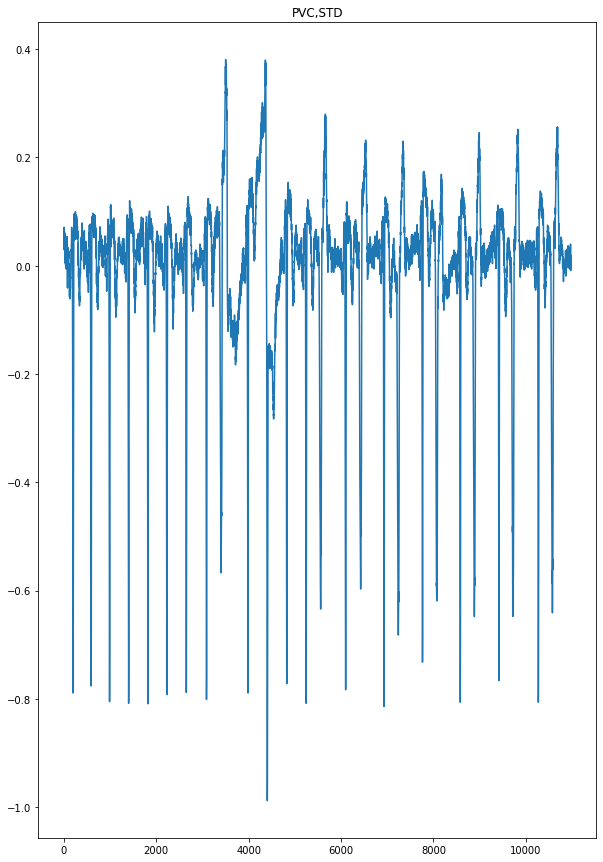

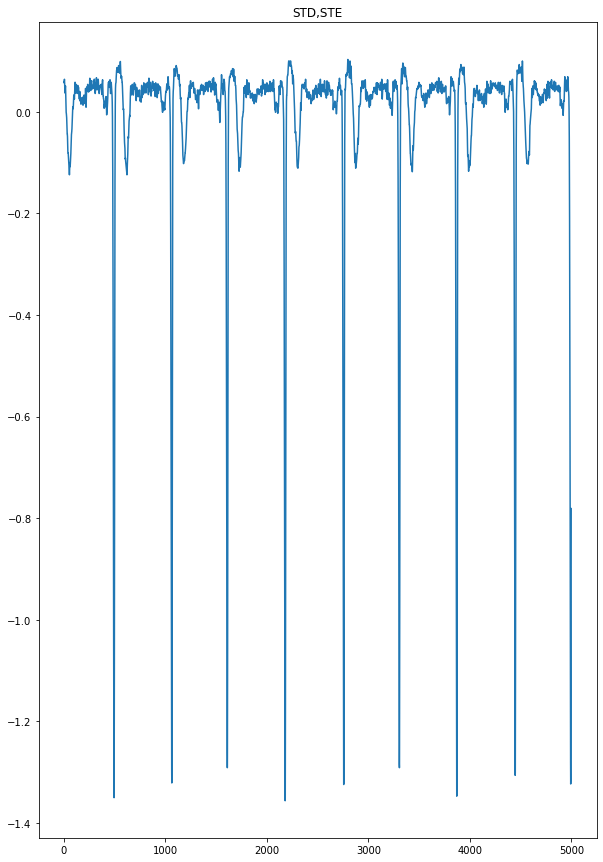

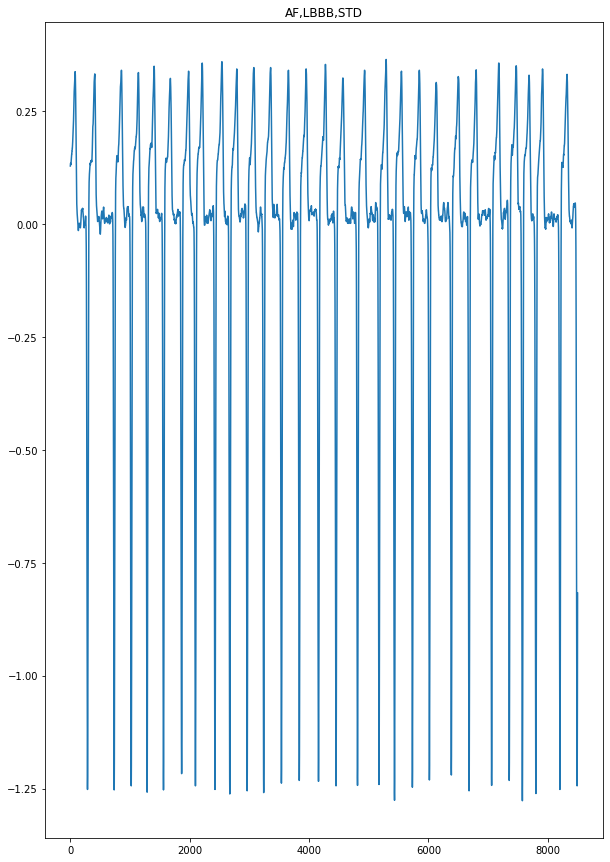

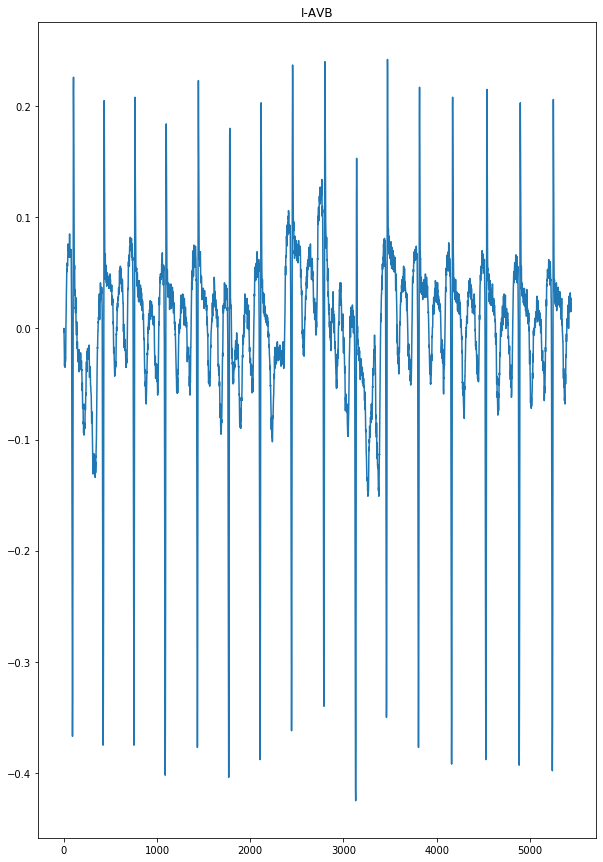

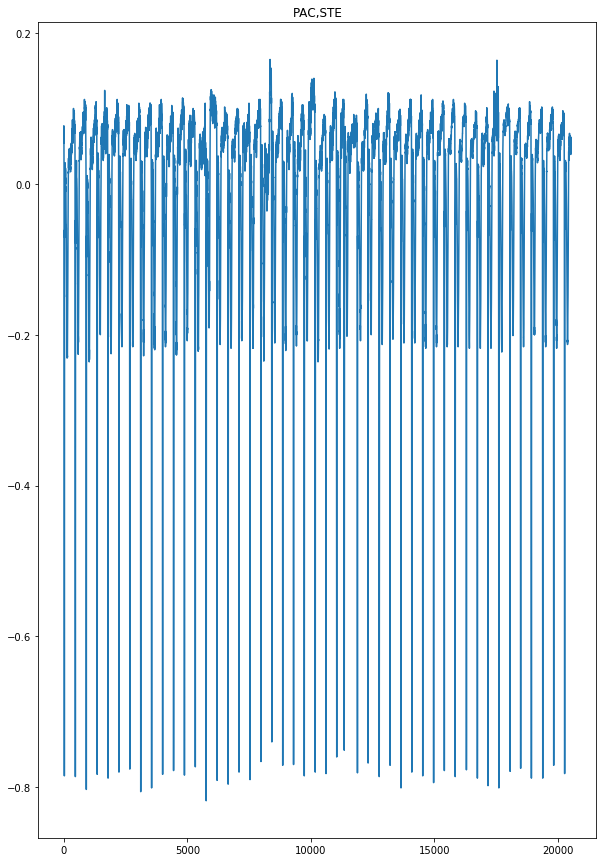

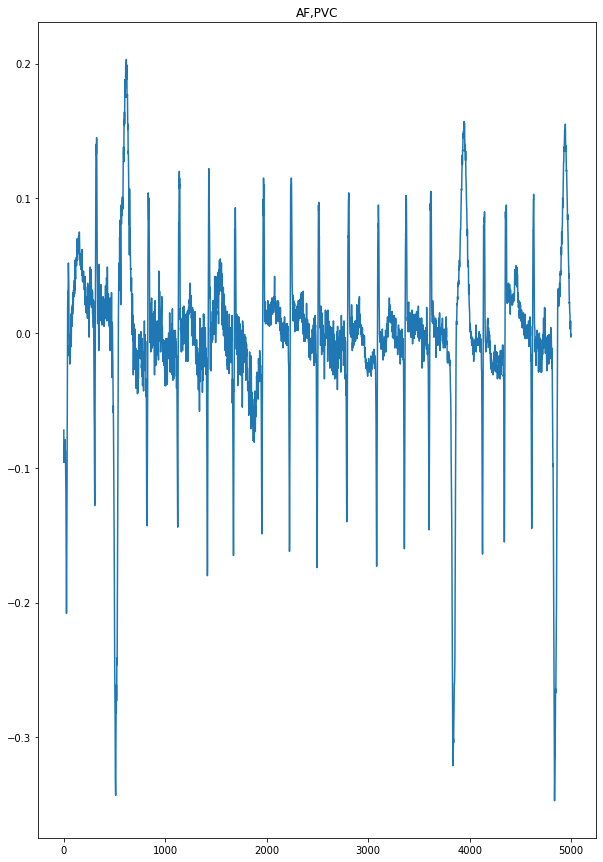

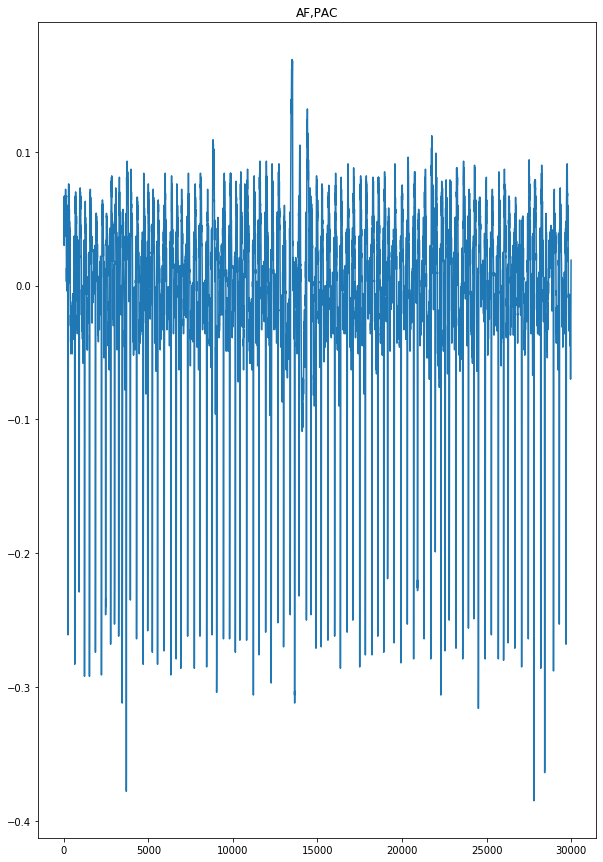

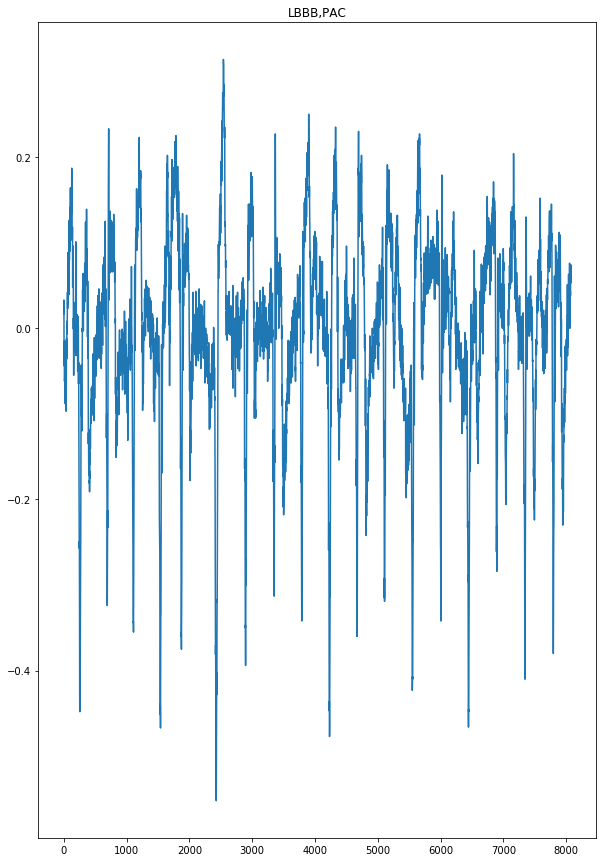

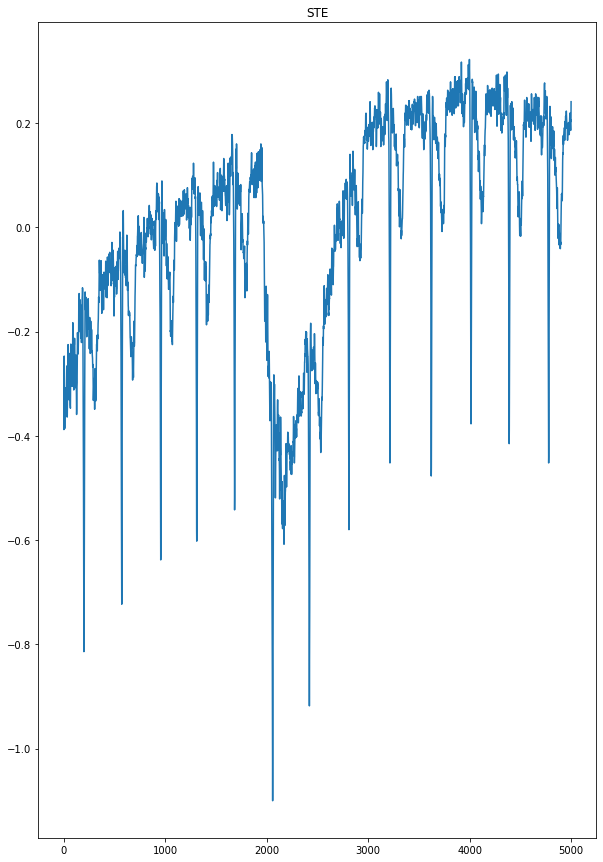

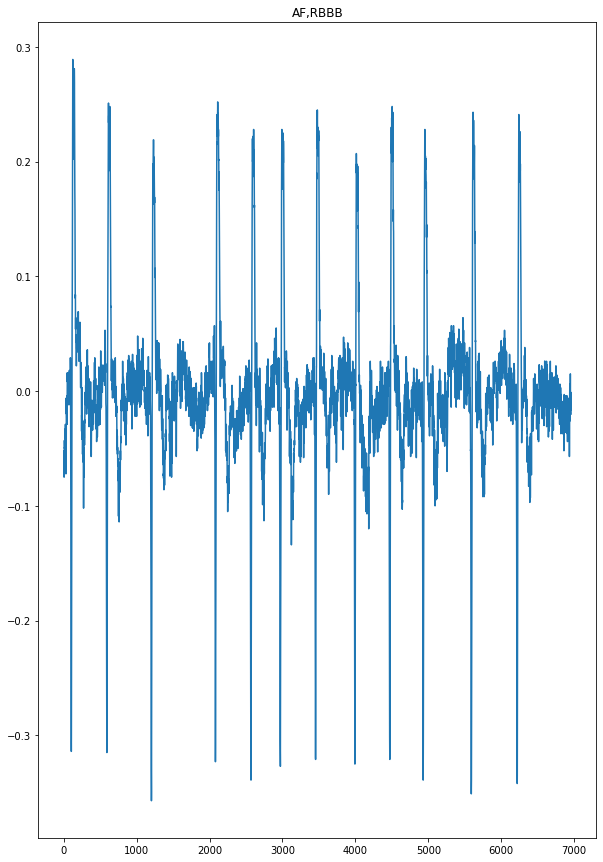

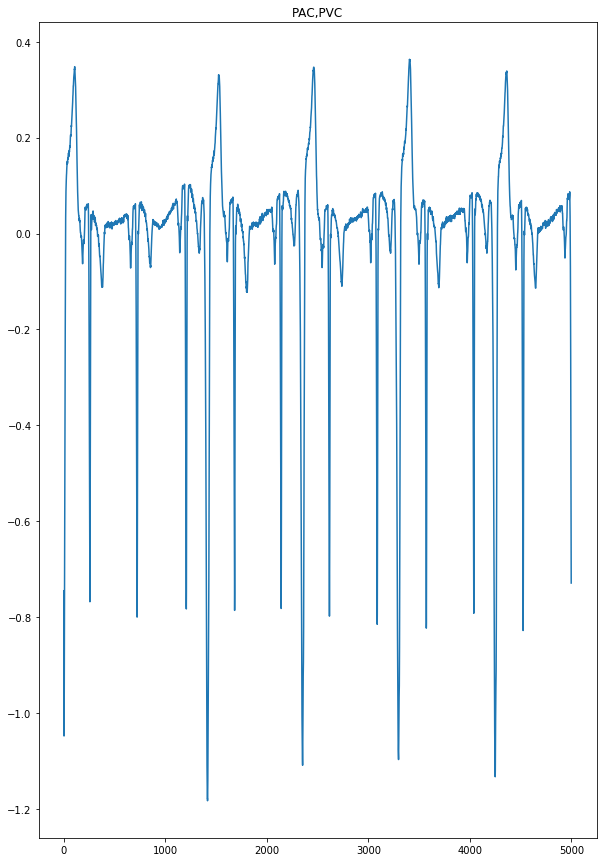

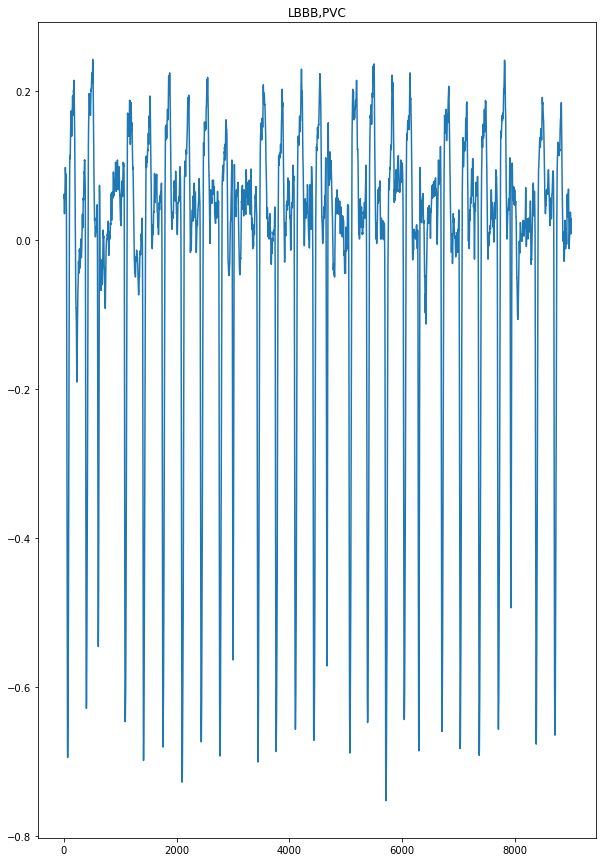

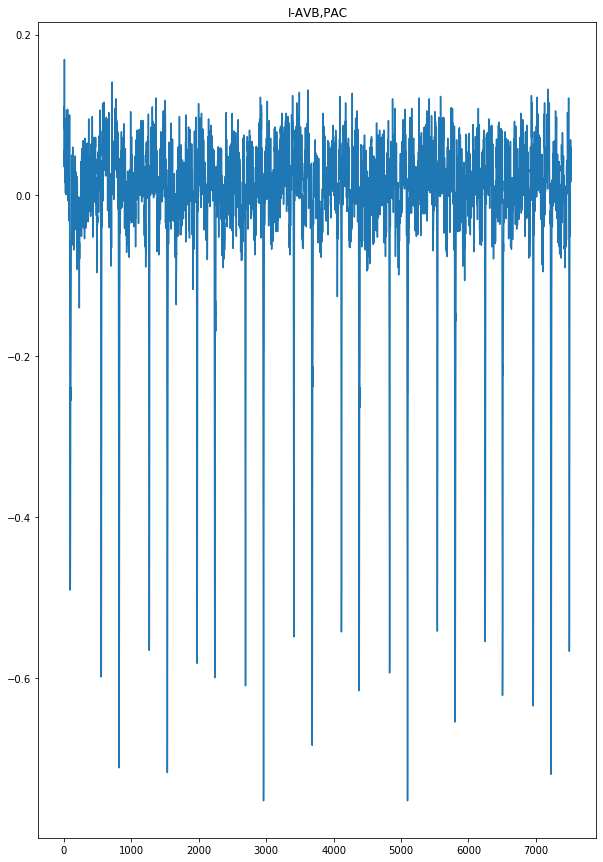

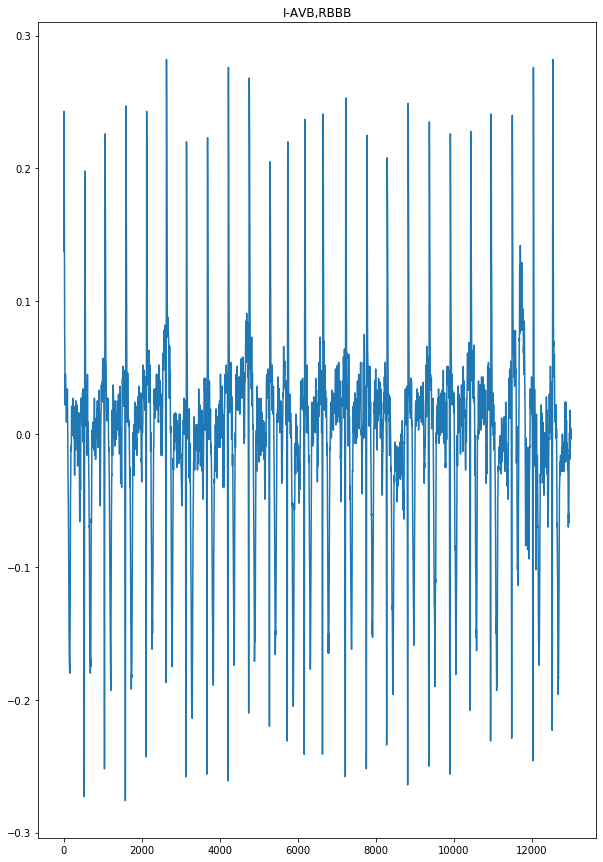

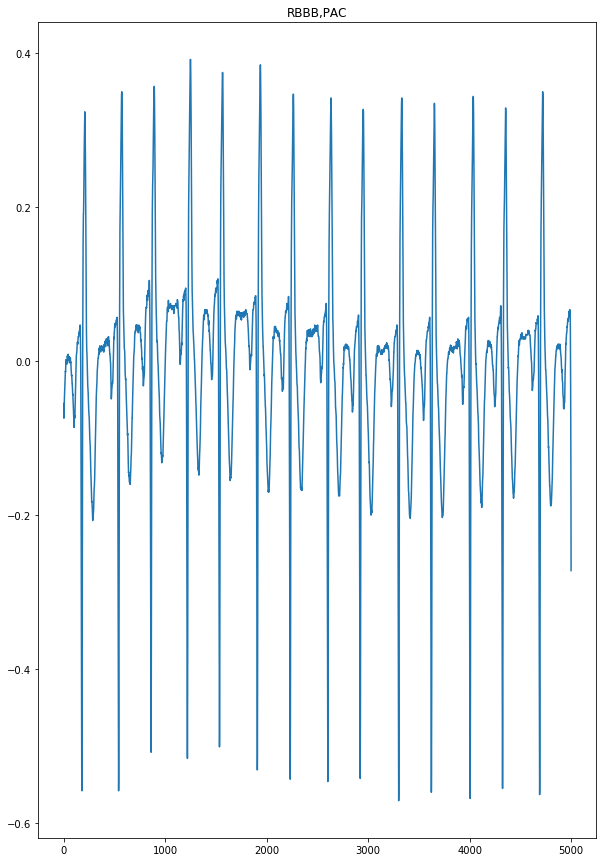

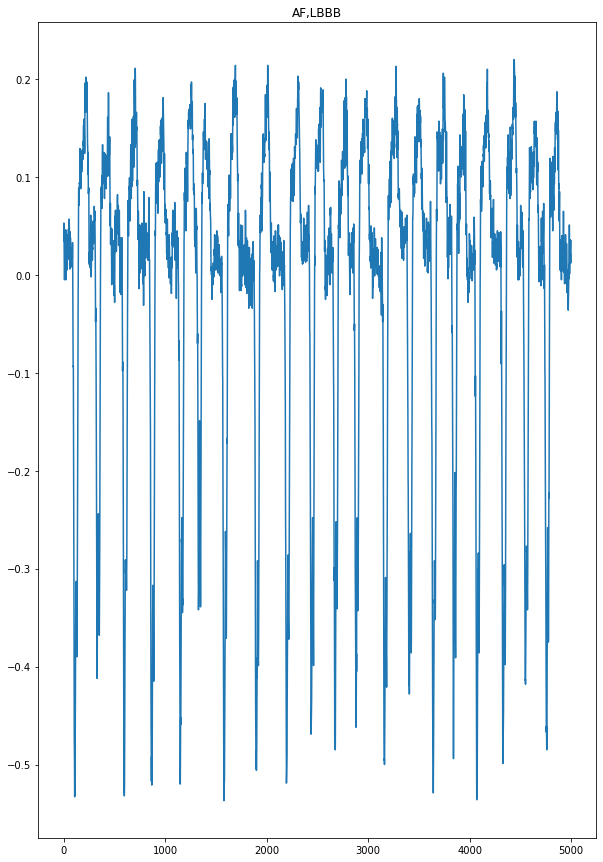

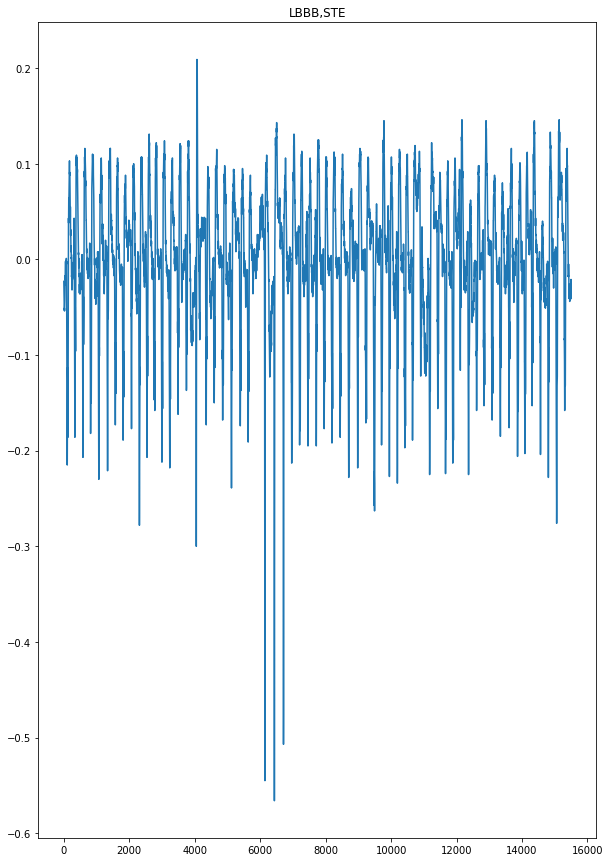

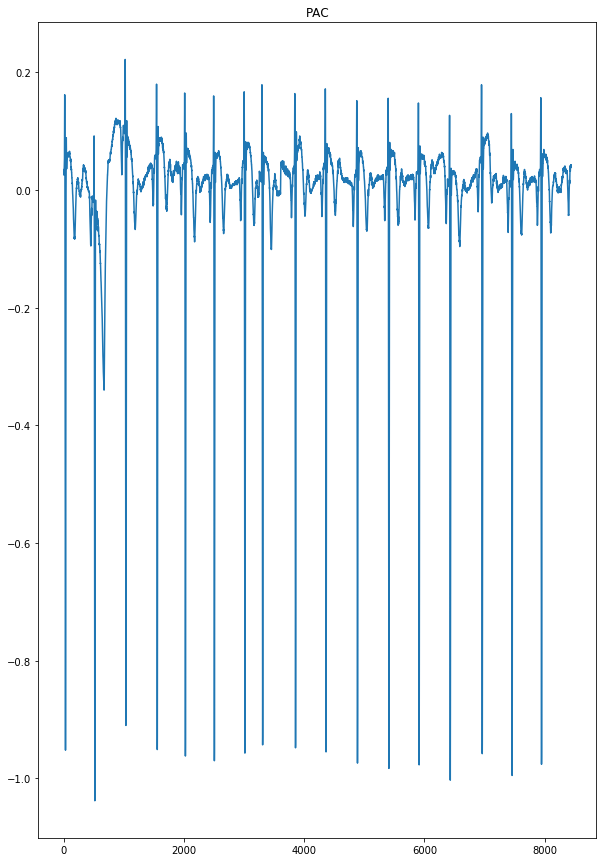

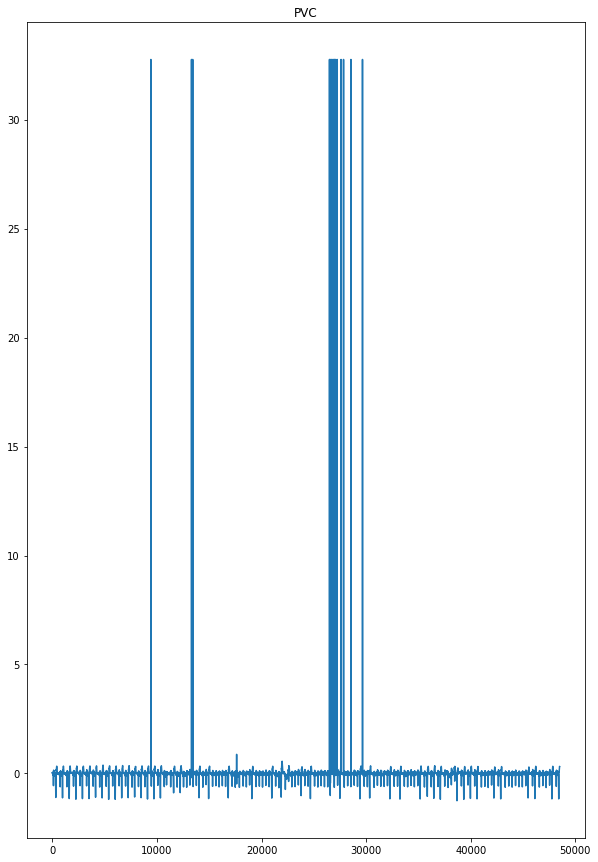

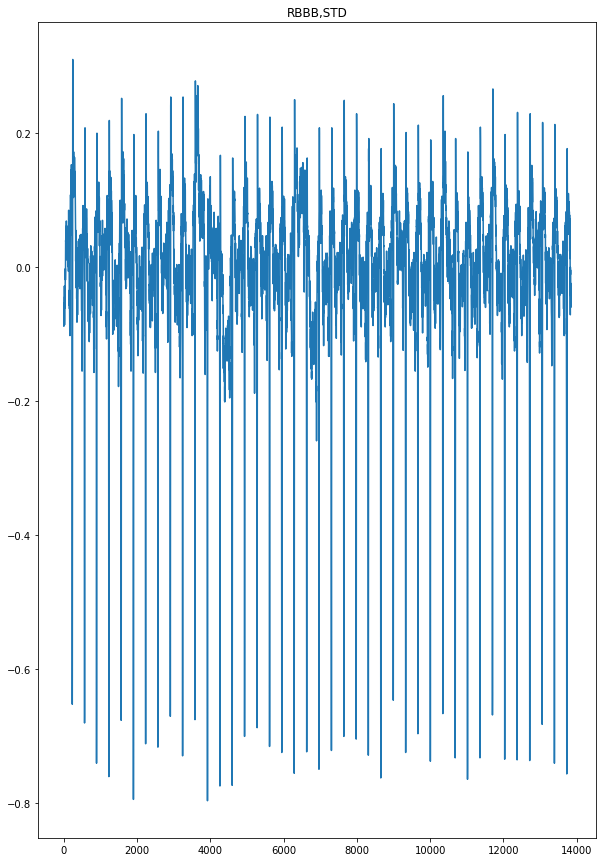

In [3]:
import wfdb
import os
import matplotlib.pyplot as plt

def plot_each_example():
    i = 0
    j = 0
    data_dir = os.getcwd()+"/data/"
    for (dirpath, dirs, files) in os.walk(data_dir):
        for dir in dirs:
            for (dirpath_interior, dirs_interior, files_interior) in os.walk(data_dir + dir + "/"):
                file = wfdb.io.rdsamp(data_dir + dir + "/" + files_interior[0][:-4])
                plt.figure(figsize=(10,15))
                plt.plot(file[0][:,3])
                plt.title(dir)
                j += 1
                if j > 5:
                    j = 0
                    i += 1
                break

    plt.show()

plot_each_example()

As visible on the plots above we can distinguish 9 main conditions which we want to classify. However a catching poing is to be found in the specification of a task stated by the PhysionetChallenge. It is said, that the signal can also be classified as a mixture of up to 3 different conditions, which creates an aboundance of possibilites. Therefore it is possible to visualise other signals of existing combinations - as it gives us an amount of more than 300 possible combinations I've limited my visualisation to only those, which were provided along with the dataset offered by the Organizators of the challenge. Signals of provided combinations are also presented above. 

## Description of the training process

In [ ]:
for folder_name in dirs:
    name = folder_name.split("/")[-1]
    checkpoint_name = name + "_" + checkpoint_name_BASE

    if os.path.isfile(checkpoint_name):
        continue

    net = NBeatsNet(stack_types=[NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK],
                    forecast_length=forecast_length,
                    thetas_dims=[7, 8],
                    nb_blocks_per_stack=3,
                    backcast_length=backcast_length,
                    hidden_layer_units=128,
                    share_weights_in_stack=False,
                    device=device)
    optimiser = optim.Adam(net.parameters())

    test_losses = []
    actual_class_dir = data_dir + "/" + name + "/"
    for (_, dirs, files) in os.walk(actual_class_dir):
        iteration = 0
        for file in files:

            if 'mat' in file:
                continue

            iteration += 1
            print(iteration)
            if iteration > 30:
                break

            data, x_test, y_test, norm_constant = naf.one_file_training_data(actual_class_dir, file, forecast_length,
                                                                         backcast_length, batch_size)

            for i in range(10):
                naf.eval_test(backcast_length, forecast_length, net, norm_constant, test_losses, x_test, y_test)
                naf.train_100_grad_steps(checkpoint_name, data, device, net, optimiser, test_losses)

As visible in a chunk of code above the whole training process creates a model for each distinctive class and then, loading files containing the signals of only the patiens with a given heart condition, runs a training loop which in each run tries to optimise the parameters and do a quick evaluation. 
This process allows me to have 9 different neural nets, each specified in regressing only one type of ECG signal - this is a base assumption laying under the whole thesis. 

## Loading models

In [4]:
algorithm = Model()
algorithm.load()

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=1500, forecast_length=500, share_thetas=False) at @140170821085112
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=1500, forecast_length=500, share_thetas=False) at @140170821084328
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=1500, forecast_length=500, share_thetas=False) at @140170821084832
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=1500, forecast_length=500, share_thetas=False) at @140170821086568
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=1500, forecast_length=500, share_thetas=False) at @140170821086512
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=1500, forecast_length=500, share_thetas=False) at @140170821086624
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(uni

## Visualising models results

In [6]:
data_dir = os.getcwd()+"/data/"
from driver import load_challenge_data
forecast_length = 500
backcast_length = 3 * forecast_length
batch_size = 256
iteration = 0;
y_true = []
y_pred = []
ranges = {}
for (dirpath, dirs, files) in os.walk(data_dir):
    for dirr in dirs:
        for (dirpath_interior, dirs_interior, files_interior) in os.walk(data_dir + dirr + "/"):
            start_index = iteration
            for file in files_interior:

                if 'hea' in file:
                    continue
                
                iteration += 1
                print(iteration, dirr)
                
                actual_class_dir = data_dir+dirr+"/"
                #data, x_test, y_test, norm_constant = naf.one_file_training_data(actual_class_dir, file, forecast_length,
                #                                                        backcast_length, batch_size)
                data, header = load_challenge_data(actual_class_dir+file)
                print(algorithm.predict(data, header))
                y_true.append('')
                
     
            


1 PVC,STE
['A4231 12 500 7000 05-Feb-2020 11:39:16\n', 'A4231.mat 16+24 1000/mV 16 0 -93 -2838 0 I\n', 'A4231.mat 16+24 1000/mV 16 0 19 -2882 0 II\n', 'A4231.mat 16+24 1000/mV 16 0 112 -44 0 III\n', 'A4231.mat 16+24 1000/mV 16 0 36 -1041 0 aVR\n', 'A4231.mat 16+24 1000/mV 16 0 -102 2517 0 aVL\n', 'A4231.mat 16+24 1000/mV 16 0 65 -2432 0 aVF\n', 'A4231.mat 16+24 1000/mV 16 0 46 -1074 0 V1\n', 'A4231.mat 16+24 1000/mV 16 0 -26 1065 0 V2\n', 'A4231.mat 16+24 1000/mV 16 0 11 -1709 0 V3\n', 'A4231.mat 16+24 1000/mV 16 0 -12 2830 0 V4\n', 'A4231.mat 16+24 1000/mV 16 0 26 -2002 0 V5\n', 'A4231.mat 16+24 1000/mV 16 0 34 2779 0 V6\n', '#Age: 70\n', '#Sex: Male\n', '#Dx: PVC,STE\n', '#Rx: Unknown\n', '#Hx: Unknown\n', '#Sx: Unknows\n']
{'LBBB': 0.1666136384010315, 'STD': 0.53645259141922, 'Normal': 0.3017529845237732, 'RBBB': 0.1518305242061615, 'AF': 0.12829840183258057, 'I-AVB': 0.20835307240486145, 'STE': 0.3996207118034363, 'PAC': 0.16887827217578888, 'PVC': 0.2004038691520691}
{'LBBB': 0, '

KeyboardInterrupt: 

## Measuring the distances

## Building a classifier

## Measuring classification results

## Final toughts